# Q-Network Learning

In [2]:
import gym
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
# %matplotlib notebook

In [3]:
env = gym.make('FrozenLake-v0')

In [4]:
def plot_centiles(ss, xmax=0, smooth_factor=1, color="orange", ylabel="Steps", filename="plot"):

    if smooth_factor > 1:
        ns = []
        for ei in range(0, len(ss)):
            ne = smoothen(ss[ei], smooth_factor)
            ns.append(ne)
        ss = ns
    episode_length = len(ss[0])
    xs = np.linspace(0, episode_length - 1, episode_length)
    mins = np.min(ss, axis=0)
    maxs = np.max(ss, axis=0)
    q1s = np.percentile(ss, 25, axis=0)
    medians = np.percentile(ss, 50, axis=0)
    q3s = np.percentile(ss, 75, axis=0)

    bg_color = 'white'
    fg_color = 'black'
    fig = plt.figure(facecolor=bg_color, edgecolor=fg_color)
    ax = fig.add_subplot(111)
    ax.patch.set_facecolor(bg_color)
    ax.xaxis.set_tick_params(color=fg_color, labelcolor=fg_color)
    ax.yaxis.set_tick_params(color=fg_color, labelcolor=fg_color)
    ax.spines['bottom'].set_color(fg_color)
    ax.spines['left'].set_color(fg_color)
    ax.spines['top'].set_color(bg_color)
    ax.spines['right'].set_color(bg_color)
    ax.xaxis.label.set_color(fg_color)
    ax.yaxis.label.set_color(fg_color)
    plt.grid(True)
    plt.xlabel('Episodes')
    plt.ylabel(ylabel)

    if color == "green":
        mean_color = 'seagreen'
        stdev_color = '#88ff99'
        maxmin_color = '#ccffdd'
    else:
        mean_color = '#ff8000'
        stdev_color = '#ffb266'
        maxmin_color = '#ffcc99'

    if xmax != 0:
        plt.gca().set_ylim(top=xmax)

    line1, = plt.plot(xs, medians, color=mean_color)
    line2, = plt.plot(xs, q3s, color=stdev_color)
    line3, = plt.plot(xs, q1s, color=stdev_color)
    line4, = plt.plot(xs, maxs, color=maxmin_color, alpha=0.5)
    line5, = plt.plot(xs, mins, color=maxmin_color, alpha=0.5)
    plt.fill_between(xs, medians, mins, facecolor=maxmin_color, alpha=0.8)
    plt.fill_between(xs, medians, maxs, facecolor=maxmin_color, alpha=0.8)
    plt.fill_between(xs, q1s, q3s, facecolor=stdev_color)
    plt.xticks(np.arange(0, num_episodes, step=num_episodes / 10))
    legend = plt.legend((line1, line2, line5), ('Median', 'Quartile 1/3', 'Maximum/Minimum'))
    for text in legend.get_texts():
        text.set_color(fg_color)
    frame = legend.get_frame()
    frame.set_facecolor(bg_color)
    frame.set_edgecolor(bg_color)
    plt.show()
    fig.savefig(filename + ".png", dpi=500, facecolor=fig.get_facecolor(), edgecolor=fig.get_edgecolor())


def smoothen(l, f):
    nl = np.zeros(len(l) - f)
    for li in range(0, len(l) - f):
        nl[li] = np.mean(l[li:li + f])
    return nl

#### The Network

In [5]:
# These lines establish the feed-forward part of the network used to choose actions
inputs1 = tf.placeholder(shape=[1, 16], dtype=tf.float32)
W = tf.Variable(tf.random_uniform([16, 4], 0, 0.01))
Qout = tf.matmul(inputs1, W)
predict = tf.argmax(Qout, 1)

# Below we obtain the loss by taking the sum of squares difference between the target and prediction Q values.
nextQ = tf.placeholder(shape=[1, 4], dtype=tf.float32)
loss = tf.reduce_sum(tf.square(nextQ - Qout))
trainer = tf.train.GradientDescentOptimizer(learning_rate=0.1)
updateModel = trainer.minimize(loss)

#### Training

In [7]:
init = tf.initialize_all_variables()

# Set learning parameters
gamma = .99
epsilon = 0.1
num_episodes = 3000
num_trials = 10
# Create lists to contain total rewards and steps per episode
esList = []
erList = []
with tf.Session() as sess:
    sess.run(init)
    for j in range(num_trials):
        sList = []
        rList = []
        for i in range(num_episodes):
            # Reset environment and get first new observation
            s = env.reset()
            rtot = 0
            done = False
            step = 0
            # The Q-Network
            while not done:
                # Choose an action by greedily (with e chance of random action) from the Q-network
                a, allQ = sess.run([predict, Qout], feed_dict={inputs1: np.identity(16)[s: s + 1]})
                if np.random.rand(1) < epsilon:
                    a[0] = env.action_space.sample()
                # Get new state and reward from environment
                s1, r, done, _ = env.step(a[0])

                # Inference for Q-values
                # Obtain the Q' values by feeding the new state through our network
                Q1 = sess.run(Qout, feed_dict={inputs1: np.identity(16)[s1: s1 + 1]})

                # Calculate target values
                # Obtain maxQ' and set our target value for chosen action
                maxQ1 = np.max(Q1)
                targetQ = allQ
                targetQ[0, a[0]] = r + gamma * maxQ1

                # Update network
                # Train our network using target and predicted Q values
                _, W1 = sess.run([updateModel, W], feed_dict={inputs1: np.identity(16)[s: s + 1], nextQ: targetQ})

                # Update environment and reduce exploration rate
                step += 1
                rtot += r
                s = s1
                if done:
                    # Reduce chance of random action as we train the model
                    epsilon = 1. / ((i / 50) + 10)

            sList.append(step)
            rList.append(rtot)

        esList.append(sList)
        erList.append(rList)

#### Rewards

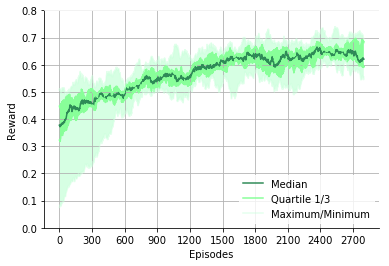

In [10]:
plot_centiles(erList, .8, smooth_factor=200, color="green", ylabel="Reward", filename="q-table-FrozenLake")

#### Number of Steps

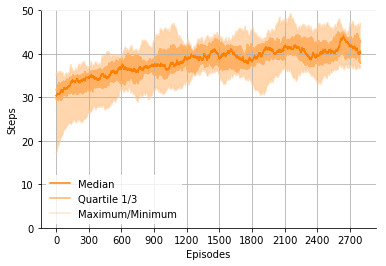

In [12]:
plot_centiles(esList, 50, smooth_factor=200, filename="q-table-FrozenLake-reward")